# Offline Simulation
The goal here is to debug why simulated offline decoding performance is worse than validation/test accuracy using EEGNet-2,2. The same data will be used for training and testing EEGNet-2,2 (BM_dataset_movement_1). To determine the discrepency between online decoding and offline I trianing I will do the following:
1. I will set up an offline simulation, run it, and visualize the decoder output along with the accuracy at each time instance.
2. I will check the results on each test example

## BCI Offline Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import preprocessing as pre
%matplotlib qt

from preprocessing import load_data, parse_labels, partition_data, augment_data
from train import train
from torch.utils.data import TensorDataset, DataLoader
import torch
import pdb
from EEGNet import EEGNet
import argparse
import tqdm

In [3]:
# run the offline simulation
'''
Simulates real-time decoding of offline EEG data

Brandon McMahan
October 4, 2021
'''
import data.data_util as util
import numpy as np
from offline_modules import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import CenterCrop
import matplotlib.pyplot as plt
import tqdm
import pdb 
from preprocessing import bandpass_channels

###########################################################################
# Module Constructors
###########################################################################
# EEG Filter constructor
zi = None


# NEXT NEIGHBORS LAPLACIAN FILTERING
electrode_names = ['Fp1', 'Fpz', 'Fp2',
          'F7', 'F3', 'Fz', 'F4', 'F8',
          'FC5', 'FC1', 'FC2', 'FC6',
          'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2',
          'CP5', 'CP1', 'CP2', 'CP6',
          'P7', 'P3', 'Pz', 'P4', 'P8', 'POz',
          'O1', 'O2', 'EOG',
          'AF7', 'AF3', 'AF4', 'AF8',
          'F5', 'F1', 'F2', 'F6',
          'FC3', 'FCz', 'FC4',
          'C5', 'C1', 'C2', 'C6',
          'CP3', 'CP4',
          'P5', 'P1', 'P2', 'P6',
          'PO5', 'PO3', 'PO4', 'PO6',
          'FT7', 'FT8', 'TP7', 'TP8',
          'PO7', 'PO8', 'Oz']

inds_original = np.array([
    [0, 4], [0, 5], [0, 6], [2, 1], [2, 3], [2, 5], [2, 7], [2, 9],
    [3, 2], [3, 4], [3, 6], [3, 8], [4, 0], [4, 1], [4, 3], [4, 5], [4, 7], [4, 9], [4, 10], 
    [5, 2], [5, 4], [5, 6], [5, 8], [6, 1], [6, 3], [6, 5], [6, 7], [6, 9],
    [7, 5], [8, 4], [8, 6], [0, 0], [1, 1], [1, 3], [1, 7], [1, 9],
    [2, 2], [2, 4], [2, 6], [2, 8], [3, 3], [3, 5], [3, 7],
    [4, 2], [4, 4], [4, 6], [4, 8], [5, 3], [5, 7],
    [6, 2], [6, 4], [6, 6], [6, 8],
    [7, 2], [7, 3], [7, 7], [7, 8],
    [3, 1], [3, 9], [5, 1], [5, 9], [7, 1], [7, 9], [8, 5]
    ])
GRIDSHAPE = (11, 9)

inds_grid = np.zeros(GRIDSHAPE, dtype='int')*np.nan
for i, ind in enumerate(inds_original):
    inds_grid[ind[1], ind[0]] = i

next_neighbors = [] # if horizontal distance is 2 or vertical distance is 2
for i, ind in enumerate(inds_original):
    iy, ix = ind

    neighbors_i = []
    if ix > 1 and ~np.isnan(inds_grid[ix-2, iy]):
        neighbors_i.append(int(inds_grid[ix-2, iy]))
    if ix < GRIDSHAPE[0]-2 and ~np.isnan(inds_grid[ix+2, iy]):
        neighbors_i.append(int(inds_grid[ix+2, iy]))
    if iy > 1 and ~np.isnan(inds_grid[ix, iy-2]):
        neighbors_i.append(int(inds_grid[ix, iy-2]))
    if iy < GRIDSHAPE[1]-2 and ~np.isnan(inds_grid[ix, iy+2]):
        neighbors_i.append(int(inds_grid[ix, iy+2]))
    next_neighbors.append(neighbors_i)
next_adjacency = np.zeros((64, 64))
for i, neighbors_i in enumerate(next_neighbors):
    next_adjacency[i, neighbors_i] = 1
D = 64
laplacian_next = np.eye(D) - (next_adjacency/np.maximum(np.sum(next_adjacency, axis=1), 1)).T
laplacian_next = torch.FloatTensor(laplacian_next).cuda()  # put on device

# load offline-trained EEGNet
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   groups=in_channels, bias=bias, padding=0)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 
                                   kernel_size=(1,1), bias=bias)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class ConstrainedDepthwiseConv2d(nn.Conv2d):
    def __init__(self, F1, D):
        super(ConstrainedDepthwiseConv2d, self).__init__(F1, F1*D, (59, 1), groups=F1)
        self._max_norm_val = 1
        self._eps = 0.01
    def forward(self, input):
        return F.conv2d(input, self._max_norm(self.weight), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
    def _max_norm(self, w):
        norm = w.norm(2, dim=0, keepdim=True)
        desired = torch.clamp(norm, 0, self._max_norm_val)
        return w * (desired / (self._eps + norm))

class ConstrainedDense(nn.Linear):
    def __init__(self):
        super(ConstrainedDense, self).__init__(4, 2)   # Inputs to dense should be F2
        self._max_norm_val = 0.25
        self._eps = 0.01
    def forward(self, input):
        return F.linear(input, self._max_norm(self.weight), self.bias)
    def _max_norm(self, w):
        norm = w.norm(2, dim=0, keepdim=True)
        desired = torch.clamp(norm, 0, self._max_norm_val)
        return w * (desired / (self._eps + norm))

class EEGNet(nn.Module):

    def __init__(self, input_length=1, input_dim=63, output_dim=2, F1=2, D=2, F2=4):
        super(EEGNet, self).__init__()

        self.T = 1000  # timestamps in data
        self.C = 59    # electrodes in data

        # BLOCK 1 LAYERS
        self._input_crop = CenterCrop([59, 1000]).cuda()
        
        # layer 1
        self._conv1 = nn.Conv2d(1, F1, (1, 500), padding=0).cuda()
        self._batchnorm1 = nn.BatchNorm2d(F1, False).cuda()

        # layer 2
        self._depthwise = ConstrainedDepthwiseConv2d(F1, D).cuda()  #nn.Conv2d(F1, F1*D, (59, 1), groups=F1).cuda()
        self._batchnorm2 = nn.BatchNorm2d(F1*D).cuda()
        self._avg_pool = nn.AvgPool2d((1,31)).cuda()
        self._dropout1 = nn.Dropout(p=0.5).cuda()

        # seperable convolution
        self._seperable = SeparableConv2d(F1*D, F2, (1,16)).cuda()
        self._batchnorm3 = nn.BatchNorm2d(F2).cuda()
        self._dropout2 = nn.Dropout(p=0.5).cuda()
        self._dense = ConstrainedDense().cuda()

        #self.input_dim = input_dim
        #self.output_dim = output_dim
        #if not isinstance(input_length, int):
        #    raise ValueError('input_length must be an int')
        #self.input_length = input_length
        #self.fc_dims = (input_dim*input_length, output_dim)
        #self.fc = nn.Linear(*self.fc_dims)

    def forward(self, x):
        if isinstance(x, np.ndarray):  # cast to PyTorch tensor
            x = torch.FloatTensor(x)

        # input to model should be (batch_size, 1, electrodes, t_steps)
        X = self.reshape_input(x)
        
        # BLOCK 1
        #X = CenterCrop(X)
        X = self._conv1(X)
        X = self._batchnorm1(X)
        X = self._depthwise(X)
        X = self._batchnorm2(X)
        X = nn.ELU()(X)
        X = self._avg_pool(X)
        X = self._dropout1(X)

        # BLOCK 2
        X = self._seperable(X)
        #X = self._batchnorm3(X)
        X = nn.ELU()(X)
        X = self._dropout2(X)
        X = torch.flatten(X, start_dim=1)
        X = self._dense(X)
        X = nn.Softmax()(X)

        return X


    def reshape_input(self, x):
        '''
        x will be shape (1000, 64)
        Reshapes X to (1, 1, 64, 1000) which is batch_size, input_channels, electrodes, timesteps

        at inference the batch size will be 1
        the channel dimension is always 1 since EEG is interpreted as a greyscale image
        we only take 59 channels 
        we have a 64 chanel system
        and we have 1000 timesteps in a second
        '''
        x = torch.transpose(x, 0, 1).cuda()   # x is now (64, 100)        # use for online
        #pdb.set_trace()
        #x = x.permute(0,3,1,2).cuda()              # use for offline
        x = self._input_crop(x)      # (59, 1000)
        x = torch.unsqueeze(torch.unsqueeze(x, 0), 0) # (1, 1, 59, 1000)   # use for online
        return x

init_path = "C:/Users/DNNeu/KaoLab/EEG_Decoding/Offline_EEG_Decoding/trained_models/trained_EEGNet-2,2"
model = EEGNet()
model.load_state_dict(torch.load(init_path))

# decoder params
decoded_x = 0
elapsed_cue_steps = 0
###########################################################################

# load in the offline data
fpath = "data/JN_movement_w_feedback_0"
eeg_data = util.load_data(fpath + "/eeg.bin")
task_data = util.load_data(fpath + "/task.bin")

# extract mean
eeg_data['databuffer'] = pre.bandpass_channels(eeg_data['databuffer'][:, 0:64])
eeg_data['databuffer'] = torch.from_numpy(eeg_data['databuffer']).cuda()
eeg_data['databuffer'] = eeg_data['databuffer']@laplacian_next.T
#eeg_data['databuffer'] = pre.normalize_channels(eeg_data['databuffer'])
z_mean = torch.mean(eeg_data['databuffer'][:,0:64], axis=0)
z_std = torch.std(eeg_data['databuffer'][:,0:64], axis=0)
assert False
eeg_data['databuffer'] = (eeg_data['databuffer']-z_mean) / z_std
# main loop over time in trial
# set the starting time
# increment the starting time by 20ms at every step

# load in different data to run in online decoder
fpath = "data/BM_movement_feedback_1"
eeg_data = util.load_data(fpath + "/eeg.bin")
task_data = util.load_data(fpath + "/task.bin")

start_time = np.min(eeg_data["time_ns"])  # time of first EEG sample in nanoseconds
end_time = np.max(eeg_data["time_ns"])  # time of last EEG sample in nanoseconds

sim_time = start_time + 20000000 # 20 ms timestep

'''
Simulator output has 4 arrays
time (ms)
state of task
decoded P(left)
decoded P(right)
decoded x-position
'''
# generate simulation time steps
sim_times = []
while (sim_time < end_time):
    sim_times.append(sim_time)
    sim_time+=20000000

simulator_output = np.zeros((5, len(sim_times) + 1))
ix = 0
old_eeg_ix = 0
eeg_buffer_signal = np.zeros_like(eeg_data["eegbuffersignal"])


offline_model = EEGNet(F1=2, D=2)  #torch.load("trained_models/" + args.EEGNet_name + ".pt")
offline_model.load_state_dict(torch.load("trained_models/trained_EEGNet-2,2"))
offline_model.eval()

for sim_time in tqdm.tqdm(sim_times):  
    # compute the eeg and task indices
    curr_eeg_ix = np.where(eeg_data["time_ns"] > sim_time)[0][0]
    curr_task_ix = np.where(task_data["time_ns"] > sim_time)[0][0]

    # update the eeg and task buffers
    new_eeg_data = eeg_data["eegbuffersignal"][old_eeg_ix:curr_eeg_ix, :]  # (n_t_steps, n_electrodes)
    state_task_buffer = task_data["state_task"][:curr_task_ix]      # (n_t_steps',)       NOTE: n_t_steps' != n_t_steps

    if curr_eeg_ix > old_eeg_ix:  # if we have new eeg data
        # filter EEG data
        #eeg_buffer_signal[old_eeg_ix:curr_eeg_ix,:]
        new_eeg_data, zi = filterEEG(new_eeg_data, zi)  # filter
        new_eeg_data = new_eeg_data[:, 0:64]@laplacian_next.T.cpu().numpy() # spatial filter
        new_eeg_data = new_eeg_data - z_mean.cpu().numpy()
        new_eeg_data = new_eeg_data / z_std.cpu().numpy()
        eeg_buffer_signal[old_eeg_ix:curr_eeg_ix,0:64] = new_eeg_data

        # apply online decoder
        start_ix = np.maximum(0, curr_eeg_ix - 1000)
        decoder_pred = decode(eeg_buffer_signal[start_ix:curr_eeg_ix,:], model, laplacian_next, mean=z_mean, std=z_std)
        decoder_pred = offline_model(eeg_buffer_signal[start_ix:curr_eeg_ix, 0:64])[0]#decode(eeg_buffer_signal[-1000:curr_eeg_ix,:], model, laplacian_next, mean=z_mean, std=z_std)  # previously used eeg_data_buffer
        #print("decoder output:", decoder_pred)
        #print("decoder input:", eeg_buffer_signal[start_ix:curr_eeg_ix, 0:64].shape)
        #print("new eeg data:", new_eeg_data.shape)
        #print("curr eeg ix:", curr_eeg_ix)
        #print("start ix:", start_ix)
        # decoder_pred is (2,)
        # specifically is (p(left), p(right))

    # compute decoded position
    if state_task_buffer[-1] == 4:  # reset decoded position
        decoded_x = 0
        elapsed_cue_steps = 0  # only show the decoder after cue has been presented for 1 second
    else:
        elapsed_cue_steps += 1  # number of elapsed 20ms bins

    if elapsed_cue_steps > 50:  # only draw decoder if 
        if (decoder_pred[1] - decoder_pred[0]) > 0.6:
            decoded_x += 0.1
        elif (decoder_pred[1] - decoder_pred[0]) < -0.6:
            decoded_x += -0.1


    # increment the simulation and store outputs
    simulator_output[0, ix] = (sim_time-start_time)/1000000000  # elapsed time in ms
    simulator_output[1, ix] = state_task_buffer[-1]         # current task state
    simulator_output[2, ix] = decoder_pred[0].item()                # current P(left)
    simulator_output[3, ix] = decoder_pred[1].item()                # current P(right)
    simulator_output[4, ix] = decoded_x                      # curr decoded x-pos
    sim_time += 20000000
    old_eeg_ix = curr_eeg_ix
    ix += 1
    
    #if ix == 5000:
    #    break

simulator_output = simulator_output[:,:ix]
    
plt.plot(simulator_output[0], simulator_output[1])
plt.plot(simulator_output[0], simulator_output[2])
plt.plot(simulator_output[0], simulator_output[3])
plt.plot(simulator_output[0], simulator_output[4])

plt.legend(["Task State", "P(left)", "P(right)", "Decoded X-pos"])
plt.xlabel("Time (sec)")
plt.show()

AssertionError: 

In [7]:
z_std

tensor([4.1324e-06, 5.4769e-06, 3.9288e-06, 3.1113e-06, 2.1336e-06, 2.4442e-06,
        2.0655e-06, 2.3654e-06, 2.8693e-06, 2.5689e-06, 2.7688e-06, 2.6323e-06,
        5.8965e-06, 2.8218e-06, 1.7987e-06, 2.5700e-06, 2.1210e-06, 2.8341e-06,
        5.1364e-06, 2.5651e-06, 2.0611e-06, 2.2744e-06, 1.9638e-06, 3.4307e-06,
        2.1851e-06, 2.4798e-06, 2.1549e-06, 3.9766e-06, 3.5549e-06, 4.0597e-06,
        3.4266e-06, 7.7383e-06, 4.6822e-06, 2.7141e-06, 2.3666e-06, 2.9095e-06,
        2.0596e-06, 2.0538e-06, 2.7327e-06, 2.0009e-06, 2.2115e-06, 2.4880e-06,
        1.9676e-06, 2.4736e-06, 2.0292e-06, 1.9860e-06, 2.2351e-06, 2.7554e-06,
        3.3872e-06, 3.0229e-06, 2.0519e-06, 2.2880e-06, 3.5816e-06, 4.3070e-06,
        2.1886e-06, 3.1697e-06, 4.4126e-06, 2.8868e-06, 2.4908e-06, 3.5868e-06,
        3.3369e-06, 2.5924e-06, 2.1432e-06, 5.2947e-06], device='cuda:0')

In [64]:
laplacian_next.shape

torch.Size([64, 64])

In [109]:
plt.figure(10)
plt.plot(eeg_buffer_signal[:10000, 0:64])
plt.title("Simulation")

plt.figure(11)
plt.plot(np.transpose(data[0,:,:,0]))
plt.title("Offline (first trial)")

plt.figure(13)
#std = z_std.cpu().numpy()
#mean = z_mean.cpu().numpy()
plt.plot(eeg_data['databuffer'][:10000].cpu().numpy())
plt.title("Simulation (preprocessed and normalized)")

Text(0.5, 1.0, 'Simulation (preprocessed and normalized)')

In [71]:
plt.figure(14)
plt.plot(task_data['state_task'])

In [31]:
ix = 2000
task_data['eeg_step'][ix] - task_data['eeg_step'][ix-1]

23

In [56]:
eeg_data['databuffer'][:2853, 0:64] - mean

array([[-2.2692682e-05, -2.1029911e-05, -2.2159278e-05, ...,
         2.6499608e-06,  1.2717295e-06,  1.9897991e-06],
       [-2.4552886e-05, -2.1959777e-05, -2.3877456e-05, ...,
         4.8732255e-07, -5.5713110e-07, -3.1274652e-08],
       [-2.6303125e-05, -2.2803690e-05, -2.5493397e-05, ...,
        -1.5304253e-06, -2.2715524e-06, -1.9310544e-06],
       ...,
       [ 5.3904969e-06, -3.1097397e-06, -5.0927378e-07, ...,
        -1.1933269e-06,  3.5347346e-06,  4.6029905e-07],
       [ 4.4996214e-06, -3.9818460e-06, -9.5137818e-07, ...,
        -1.3129273e-06,  3.5288797e-06,  3.7496307e-07],
       [ 3.4515731e-06, -4.8494408e-06, -1.4338192e-06, ...,
        -1.4117735e-06,  3.5265580e-06,  3.2282054e-07]], dtype=float32)

array([ 5.4628e-11,  4.2082e-10,  2.4777e-10,  7.5516e-11,  5.3662e-11,
       -1.6719e-11,  1.4088e-11,  2.3044e-10, -9.5130e-11,  8.8514e-11,
       -1.0393e-11,  1.4649e-10,  1.7038e-10,  2.0938e-11, -5.5727e-11,
       -1.4202e-10,  3.1218e-11, -1.0551e-10, -3.0852e-11,  1.2233e-11,
       -2.7044e-11, -5.3061e-11, -3.0882e-11, -1.0780e-10,  4.7582e-11,
        9.6878e-11, -1.1857e-10, -2.0966e-11, -2.2053e-12,  1.9628e-11,
       -9.4556e-11,  7.9081e-10,  4.5097e-12,  1.9936e-10,  7.1391e-11,
        1.9369e-10,  1.4240e-10,  5.2596e-11, -9.0557e-11,  1.5168e-10,
       -1.1751e-10, -1.3228e-11, -6.1219e-11, -1.7424e-10, -9.9240e-11,
       -6.3743e-12, -3.0172e-11, -9.3875e-11,  2.6118e-11,  9.6182e-11,
        1.5962e-11,  2.6794e-11, -7.7036e-11,  8.6030e-12,  4.5420e-11,
       -6.6470e-11, -4.9431e-11,  1.1470e-10, -3.5395e-12,  7.3352e-12,
       -4.6200e-11, -5.9201e-11, -1.2082e-11, -1.6625e-10])

In [3]:
time = simulator_output[0]
sim_task_state = simulator_output[1]
p_left = simulator_output[2]
p_right = simulator_output[3]
simulated_x = simulator_output[4]

In [5]:
plt.figure(1)
plt.plot(time[sim_task_state!=4], p_right[sim_task_state!=4])
plt.plot(time[sim_task_state!=4], sim_task_state[sim_task_state!=4])

In [6]:
plt.figure(2)
plt.plot(time[sim_task_state!=4], np.clip(simulated_x[sim_task_state!=4]+0.5, 0, 1))
plt.plot(time[sim_task_state!=4], sim_task_state[sim_task_state!=4])
plt.legend(["Decoded X", "True Target"])

In [67]:
n_decoder_output = np.sum(np.clip(simulated_x[sim_task_state!=4]+0.5, 0, 1) != 0.5)
print(n_decoder_output)
accuracy_strict = np.sum(np.clip(simulated_x[sim_task_state!=4]+0.5, 0, 1) == sim_task_state[sim_task_state!=4])/n_decoder_output
print("Percentage of time target is acquired:", accuracy_strict)

accuracy_lenient = np.clip(simulated_x[sim_task_state!=4]+0.5, 0, 1) - sim_task_state[sim_task_state!=4]
accuracy_lenient = np.abs(accuracy_lenient)
accuracy_lenient = np.sum(accuracy_lenient < 0.5) / n_decoder_output
print("Percentage of time decoder is close to target:", accuracy_lenient)

15082
Percentage of time target is acquired: 0.6941387083941122
Percentage of time decoder is close to target: 0.7396896963267471


## Discrepancy between online and offline EEG data

In [94]:
# load in the data
fpath = "data/BM_movement_1"
eeg_data = util.load_data(fpath + "/eeg.bin")
task_data = util.load_data(fpath + "/task.bin")

# bandpass the data
eeg_data['databuffer'] = eeg_data['databuffer'][:, 0:64]
eeg_data['databuffer'] = pre.bandpass_channels(eeg_data['databuffer'])
eeg_data['databuffer'] = pre.next_next_neighbors_filter(eeg_data['databuffer'])
eeg_data['databuffer'] = pre.normalize_channels(eeg_data['databuffer'])

applying laplacian


In [95]:
plt.figure(11)
plt.plot(np.transpose(data[0,:,:,0]))
plt.title("Offline (first trial)")

plt.figure(13)
#std = z_std.cpu().numpy()
#mean = z_mean.cpu().numpy()
plt.plot(eeg_data['databuffer'][:10000])
plt.title("Manually loading data")

Text(0.5, 1.0, 'Manually loading data')

## EEGNet-2,2 Offline Evaluation
First look at accuracy of EEGNet-2,2

In [81]:
# Evaluate EEGNet-2,2
from preprocessing import load_data, parse_labels, partition_data, augment_data
from train import train
from torch.utils.data import TensorDataset, DataLoader
import torch
import pdb
from EEGNet import EEGNet
import argparse
import tqdm

In [82]:
data, labels = load_data(["BM_movement_1"], filter=True, normalize=True)  # BM_movement_2 held out for testing
data, labels = parse_labels(data, labels)
train_ds, val_ds, test_ds = partition_data(data, labels, splits=[0.0, 0.0, 1.0])
test_ds = augment_data(test_ds)

test_dataset = TensorDataset(torch.from_numpy(test_ds[0]).type(torch.float), torch.from_numpy(test_ds[1]).type(torch.long))
test_dataset = DataLoader(test_dataset, batch_size=128, shuffle=True)

EEGNet_model = EEGNet(F1=2, D=2)  #torch.load("trained_models/" + args.EEGNet_name + ".pt")
EEGNet_model.load_state_dict(torch.load("trained_models/trained_EEGNet-2,2"))
EEGNet_model.eval()
num_correct = 0
num_samples = 0
for i, (inputs, labels) in enumerate(tqdm.tqdm(test_dataset)):
    labels = labels.cuda()
    # forward + backward + optimize
    outputs = EEGNet_model(inputs)
    # get training accuracy
    softmax_vals, softmax_indices = outputs.max(1)
    num_correct += (softmax_indices == labels).sum()
    num_samples += softmax_indices.size(0)
accuracy = 100*num_correct / num_samples
print("Test set accuracy (%):", accuracy.item())

applying laplacian


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]C:\Users\DNNeu\kaolab\eeg_decoding\offline_eeg_decoding\EEGNet.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = nn.Softmax()(X)
100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 26.29it/s]

Test set accuracy (%): 86.07562255859375


Next, look at the accuracy of EEGNet-2,2 on a trial by trial basis

In [83]:

data, labels = load_data(["BM_movement_1"], filter=True, normalize=True)  # BM_movement_2 held out for testing
task_state = np.ones((data.shape[0], data.shape[2]-2000))
for trial_ix in range(data.shape[0]):
    if labels[trial_ix] == "left":
        task_state[trial_ix, :] = 0
    else:
        task_state[trial_ix, :] = 1
task_state.reshape(-1).shape
plt.plot(task_state.reshape(-1))
data, labels = parse_labels(data, labels)


applying laplacian


100%|████████████████████████████████████████████████████████████████████████████████████████| 206/206 [00:00<?, ?it/s]


In [42]:
labels

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1])

In [8]:
task_state = np.ones((data.shape[0], data.shape[2]-2000))
for trial_ix in range(data.shape[0]):
    task_state[trial_ix, :] = labels[trial_ix]
task_state.reshape(-1).shape
plt.plot(task_state.reshape(-1))

In [10]:
test_dataset = TensorDataset(torch.from_numpy(data).type(torch.float), torch.from_numpy(labels).type(torch.long))
test_dataset = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [11]:
EEGNet_model = EEGNet(F1=2, D=2)  #torch.load("trained_models/" + args.EEGNet_name + ".pt")
EEGNet_model.load_state_dict(torch.load("trained_models/trained_EEGNet-2,2"))
EEGNet_preds = np.zeros((data.shape[0], data.shape[2]-2000))
EEGNet_probs = np.zeros((data.shape[0], data.shape[2]-2000, 2))
trial_ix = 0
EEGNet_model.eval()
num_correct = 0
num_samples = 0
for i, (inputs, labels) in enumerate(tqdm.tqdm(test_dataset)):
    counter = 0
    labels = labels.cuda()
    # forward + backward + optimize
    for counter in range(data.shape[2]-2000):
        outputs = EEGNet_model(inputs[:,:,1000+counter:counter+2000,:])
        # get training accuracy
        softmax_vals, softmax_indices = outputs.max(1)
        EEGNet_probs[trial_ix, counter] = outputs.detach().cpu().numpy()
        num_correct += (softmax_indices == labels).sum()
        num_samples += softmax_indices.size(0)
        EEGNet_preds[trial_ix, counter] = softmax_indices.item()
    trial_ix += 1
accuracy = 100*num_correct / num_samples
print("Test set accuracy (%):", accuracy.item())

  0%|                                                                                          | 0/102 [00:00<?, ?it/s]C:\Users\DNNeu\KaoLab\EEG_Decoding\Offline_EEG_Decoding\EEGNet.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = nn.Softmax()(X)
100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [04:33<00:00,  2.68s/it]

Test set accuracy (%): 72.23174285888672


In [120]:
EEGNet_preds.shape

(102, 1854)

In [119]:
task_state.shape

(102, 2854)

In [118]:
task_state.shhape

AttributeError: 'numpy.ndarray' object has no attribute 'shhape'

In [56]:
EEGNet_preds.shape

(102, 2854)

In [57]:
EEGNet_preds

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.]])

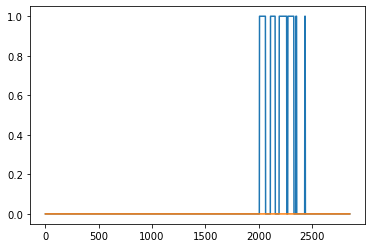

In [67]:
ix = 9
plt.plot(EEGNet_preds[ix])
plt.plot(task_state[ix])

In [62]:
task_state.shape

(102, 2854)

In [117]:
plt.plot(EEGNet_preds.reshape(-1))
plt.plot(task_state.reshape(-1))
plt.legend(['EEGNet Prediction', 'Task State (ground truth)'])
plt.title("EEGNet Predicted Outputs")

Text(0.5, 1.0, 'EEGNet Predicted Outputs')

In [90]:
correct = np.sum(EEGNet_preds.reshape(-1) == task_state.reshape(-1))
total = len(EEGNet_preds.reshape(-1))
print("accuracy (%):", 100 * correct/total)

accuracy (%): 71.91489069348833


In [79]:
EEGNet_preds.shape

(102, 2854)

In [80]:
102 * 2854

291108

In [81]:
209350 / 291108

0.7191489069348833

In [38]:
plt.figure(4)
plt.plot(EEGNet_probs[:,:,1].reshape(-1))
plt.plot(task_state.reshape(-1))
plt.legend(['EEGNet P(right)', 'Task State (ground truth)'])
plt.title("EEGNet Probabilities")

Text(0.5, 1.0, 'EEGNet Probabilities')

In [93]:
# Lets try thresholding by 0.2 probability

In [12]:
thresholded_preds = np.zeros(EEGNet_preds.shape)

In [13]:
thresholded_preds

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
EEGNet_preds.shape

(102, 1854)

In [15]:
thresholded_preds[:] = 0.5

In [16]:
thresholded_preds

array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]])

In [17]:
thresholded_preds[EEGNet_probs[:,:,1] > 0.8] = 1
thresholded_preds[EEGNet_probs[:,:,0] > 0.8] = 0


In [18]:
thresholded_preds

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, ..., 0. , 0. , 0. ],
       [1. , 0.5, 0.5, ..., 1. , 1. , 1. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0.5, 0.5],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.5, 0.5, 1. , ..., 0.5, 0.5, 0.5]])

In [19]:
plt.plot(thresholded_preds.reshape(-1))
plt.plot(task_state.reshape(-1))
plt.legend(['EEGNet Prediction', 'Task State (ground truth)'])
plt.title("EEGNet Thresholded Predicted Outputs")

Text(0.5, 1.0, 'EEGNet Thresholded Predicted Outputs')

## Draw the decoder based on simulated predictions

In [20]:
predicted_x = thresholded_preds.reshape(-1)
target_x = task_state.reshape(-1)
predicted_x.shape
target_x.shape

(189108,)

In [21]:
decoded_x = []
curr_x_pos = 0.5
for ix in range(len(predicted_x)):
    if ix %1854 == 0:  # reset decoder position
        curr_x_pos = 0.5
    if predicted_x[ix] > 0.5:
        curr_x_pos += 0.01
    elif predicted_x[ix] < 0.5:
        curr_x_pos += -0.001
    curr_x_pos = np.clip(curr_x_pos, 0, 1)
    decoded_x.append(curr_x_pos)

In [23]:
plt.figure(2)
plt.plot(predicted_x)
plt.plot(target_x)
plt.legend(["predicted", "target"])

In [178]:
len(target_x)

189108

In [179]:
len(predicted_x)

189108

In [180]:
len(decoded_x)

189108

In [24]:
plt.figure(3)
plt.plot(decoded_x)
plt.plot(target_x)
plt.legend(["predicted", "target"])

In [152]:
plt.plot(task_state.reshape(-1))

In [151]:
task_state

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [166]:
plt.plot(predicted_x)
plt.plot(predicted_x_tmp)